In [15]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a cashflow process that follows geometric brownian motion and
a constant cost rate

Typical usage example:

  foo = ClassFoo()
  bar = foo.FunctionBar()
"""

import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

In [16]:
class CashflowProcess:
    """Cashflow Process - Geometric Brownian Motion.(with optional drift).

    Longer class information...
    Longer class information...

    Attributes:
        likes_spam: A boolean indicating if we like SPAM or not.
        eggs: An integer count of the eggs we have laid.    
    """

    def __init__(self, mu: float = 0.0, sigma: float = 1.0, y0: float = 3.0,):
        """Initializes the instance based on spam preference.

        Args:
          likes_spam: Defines if instance exhibits this preference.
        """
        self.mu = mu
        self.sigma = sigma
        self.y0 = y0

    def _market_sentiment(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Generates a cumulative product array with uniform distribution draws
        at each interval period

        Parameters:
        - t (np.array): The time array
        - n (int): The number of simulations to run
        - step (int): The number of time steps in an interval
        - rnd (np.random.RandomState): The random state

        Returns:
        - np.ndarray: A market sentiment array with innovations at each interval
        """

        # create an array of zeros
        time_len = t.size
        arr = np.ones((time_len, n))

        # replace every interval entry with a uniform distribution sample
        i = step
        while i < time_len:
            arr[i] = rnd.uniform(0, 2, size=(1, n))
            i *= 2
        return np.cumprod(arr, axis=0)

    def simulate(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Simulates cashflow process"""
        
        # verify input
        assert t.ndim == 1, "One dimensional time vector required"
        assert t.size > 0, "At least one time point is required"
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), "Increasing time vector required"
        
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)

        # market sentiment array
        mkt_sent = self._market_sentiment(t, n, step, rnd)

        # run simulation
        sim = (self.y0-1) + np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T
        return sim * mkt_sent

    def distribution(self, t: float) -> rv_frozen:
        """Return the distribution of the process"""
        mu_t = (self.mu - self.sigma**2 / 2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)


In [17]:
# simulation parameters
N = 25
T = 3
step = 20
t1 = np.linspace(0, T, step*T+1)

# cost process
@np.vectorize
def cost(k):
    return 1.0

# cashflow process
r = 0.02
sigma = 0.3
cf = CashflowProcess(mu=r, sigma=sigma)


In [18]:
# simulation
rnd = RandomState(seed=1234)
cashflow = cf.simulate(t1, N, step, rnd)

In [19]:
# mask integer values so that the plot line breaks
time_mask = np.tile(np.reshape(t1, (-1, 1)), (1, N))
mask = np.mod(time_mask, 1) == 0  # Mask where x is an integer
cf_masked = np.ma.masked_where(mask, cashflow)
cf = cashflow

# sort based on final value
sorted_indices = np.argsort(cf[-1])
cf_sorted = cf[:, sorted_indices]

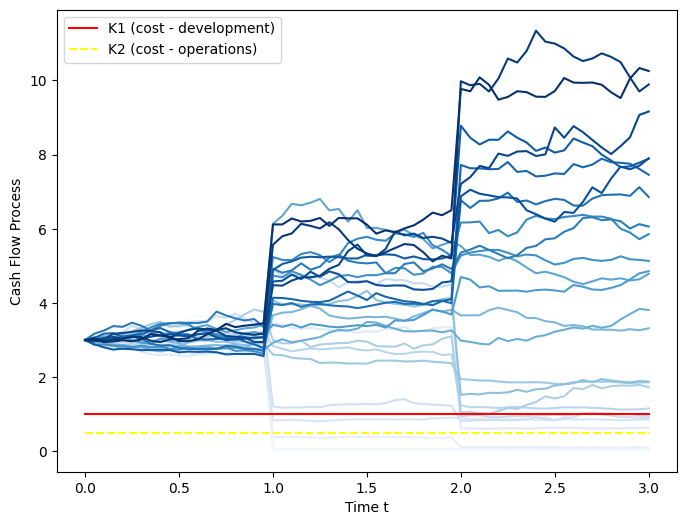


Trials: 25, Drift: 0.02, Vol: 0.3 



In [20]:
# plot cashflow and cost processes
figsize = (8, 6)
plt.figure(figsize=figsize)

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
plt.plot(t1, cf_sorted)

plt.plot(t1, cost(t1), color='red', label='K1 (cost - development)')
plt.plot(t1, cost(t1)/2, color='yellow', linestyle='dashed', label='K2 (cost - operations)')

plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.legend(loc='upper left')
plt.show()

txt = f"""
Trials: {N}, Drift: {r}, Vol: {sigma} 
"""
print(txt)


Text(0, 0.5, 'Stock Price')

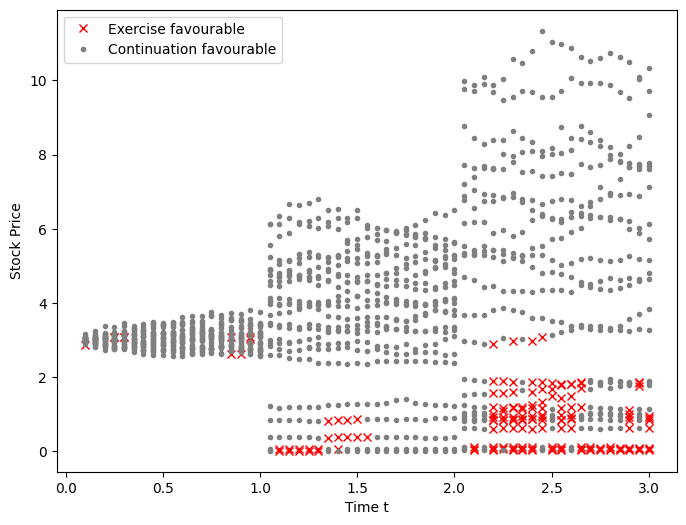

In [21]:
intermediate_results = []

def exercise_value(s):
    return np.maximum(3.1 - s, 0)

# given no prior exercise we just receive the payoff of a European option
cashflow = exercise_value(cf_sorted[-1, :])
# iterating backwards in time
for i in reversed(range(1, cf_sorted.shape[0] - 1)):
    # discount factor between t[i] and t[i+1]
    df = np.exp(-r * (t1[i + 1] - t1[i]))
    # discount cashflows from next period
    cashflow = cashflow * df
    x = cf_sorted[i, :]
    # boolean index of all in-the-money paths
    itm = exercise_value(x) > 0
    # fit polynomial of degree 2
    fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
    # approximate continuation value
    continuation = fitted(x)
    # exercise value for time t[i]
    exercise = exercise_value(x)
    # boolean index where exercise is beneficial
    ex_idx = itm & (exercise > continuation)
    # update cashflows with early exercises
    cashflow[ex_idx] = exercise[ex_idx]

    intermediate_results.append((cashflow, x, fitted, continuation, exercise, ex_idx))

exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []

for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(
    intermediate_results
):
    for ex in x[ex_idx]:
        exercise_times.append(t1[-i - 1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t1[-i - 1])
        non_exercises.append(ex)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, "rx")
plt.plot(non_exercise_times, non_exercises, ".", color="grey")
plt.legend(["Exercise favourable", "Continuation favourable"])
plt.xlabel("Time")
plt.ylabel("Cash Flow Process")
plt.show()

Text(0, 0.5, 'Cash Flow Process')

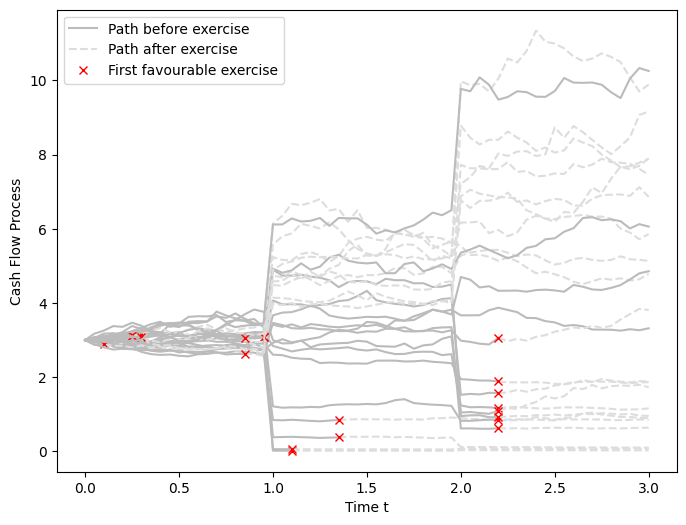

In [23]:
grey = "#dddddd"

n_timesteps, n_paths = cf_sorted.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype="int")
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(
    intermediate_results
):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype="int")
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

plt.figure(figsize=figsize)
for i in range(n_paths):
    (handle_path,) = plt.plot(
        t1[0 : first_exercise_idx[i] + 1],
        cf_sorted[0 : first_exercise_idx[i] + 1, i],
        "-",
        color="#bbbbbb",
    )
    (handle_stopped_path,) = plt.plot(
        t1[first_exercise_idx[i] :], cf_sorted[first_exercise_idx[i] :, i], "--", color=grey
    )
    if first_exercise_idx[i] < n_timesteps:
        (handle_first_ex,) = plt.plot(
            t1[first_exercise_idx[i]], cf_sorted[first_exercise_idx[i], i], "rx"
        )

plt.legend(
    [handle_path, handle_stopped_path, handle_first_ex],
    ["Path before exercise", "Path after exercise", "First favourable exercise"],
)
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
